# Making LoL_Win_Predict_Big Object Oriented

In [23]:
# Importing required libraries
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dtale

# ML related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import chi2_contingency

## Using static DataFrame to no longer need Riot API key
The file imported was generated in LoL_Win_Predict_Big.ipynb. Using a static dataframe makes testing more consistent and removes the need to request data from Riot Games, removing the need of my personal API key (which should not be shared with the public).

More information on how the data was collected can be found there in the following sections of LoL_Win_Predict_Big.ipynb:

1. Get user PUUID using their Riot ID and Tagline
2. Get user match history (past 50 games)
3. Get match information
4. Extract desired user stats for every match using their PUUID

In [2]:
# Specify the path to your Parquet file with gzip compression
file_path = 'objectives_blue_df.parquet.gzip'

# Read the Parquet file
table = pq.read_table(file_path)

# Convert the table to a Pandas DataFrame if needed
objectives_blue_df = table.to_pandas()

## Separate Features and Target Variable

In [7]:
# Extract binary objective results
X_cols = []
for col in objectives_blue_df:
    val_type = objectives_blue_df[col].dtypes
    if val_type == bool and col != 'win':
        X_cols.append(col)

# Separating X and y
X_data = objectives_blue_df[X_cols]
y_data = objectives_blue_df['win']

# Display the DataFrames
dtale.show(X_data).open_browser()
dtale.show(y_data).open_browser()

## Feature-Target Relationship
Viewing the strength of the relationship between features and winning.

In [4]:
def features_chi2(X_data):
    # Create a contingency table
    chi2_list = []
    pval_list = []

    # Checking the association between each X variable and the target variable
    for col in X_data:
        contingency_table = pd.crosstab(X_data[col], y_data)
        chi2_val, pval, _, _ = chi2_contingency(contingency_table)
        chi2_list.append(chi2_val)
        pval_list.append(pval)

    chi2_df = pd.DataFrame({'feature': X_cols, 'chi2': chi2_list, 'pval': pval_list})

    chi2_df = chi2_df.sort_values(by = 'chi2', ascending = False).reset_index(drop=True)
    return chi2_df

chi2_df = features_chi2(X_data)

print(chi2_df)

            feature        chi2          pval
0    inhibitorFirst  206.514115  7.914379e-47
1        baronFirst  116.699649  3.340054e-27
2     dragonKills_0   71.839575  2.334235e-17
3        towerFirst   66.724524  3.122265e-16
4     dragonKills_4   32.554770  1.158804e-08
5     dragonKills_1   22.728502  1.865798e-06
6       dragonFirst   22.412765  2.199076e-06
7     championFirst   22.406803  2.205912e-06
8     dragonKills_2   20.979788  4.641544e-06
9   riftHeraldFirst   18.314750  1.872518e-05
10     hordeKills_6   14.930831  1.115254e-04
11    dragonKills_3   13.692772  2.152814e-04
12     hordeKills_0   13.430207  2.476048e-04
13    dragonKills_5    9.110863  2.540959e-03
14       hordeFirst    7.957599  4.788590e-03
15     hordeKills_1    2.051322  1.520741e-01
16     hordeKills_5    1.531607  2.158714e-01
17     hordeKills_2    0.640297  4.236033e-01
18     hordeKills_3    0.491195  4.833947e-01
19     hordeKills_4    0.385742  5.345460e-01
20    dragonKills_6    0.001944  9

# Selecting a Machine Learning Model

## Using sklearn machine learning libraries
### Supervised Learning Algorithms

Since the data we are working with is labelled with wins and losses, it makes the most sense to use a supervised learning algorithm.

Models Tested:
- Logistic Regression
- K Nearest Neighbour
- Decision Tree
- Random Forest
- Gradient Boosting

## Machine Learning Model Metrics
Due to the nature of League of Legends, a player's win/loss ratio should be close to 50%, meaning the target variable "win" is well balanced. So, accuracy acts as a simple yet useful indicator of the effectiveness of our machine learning models and will be the primary metric taken into consideration when choosing a model. The win/loss ratio of this dataset is 47.8% (239/500).

Confusion Matrix = [[TN, FP], [FN, TP]]

**Accuracy = (TP + TN)/(TP + FP + TN + FN)**

Precision = TP/(TP + FP)

Recall = TP/(TP + FN)

F1 score: weighted average of precision and recall## Model Testing

In [28]:
def model_testing(X_train, X_test, y_train, y_test, model_dict):
    metric_scores_dict = {}
    
    for model_name, model_func in model_dict.items():
        
        print(f'\n#===================== {model_name} =====================#')
        model = model_func()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Create confusion matrix comparing the predicted outcomes to the real outcomes
        confusion_mat = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        print('Confusion Matrix:')
        print(confusion_mat)

        # Accuracy score
        accuracy = accuracy_score(y_test, y_pred)
        metric_scores_dict
        print(f'\nAccuracy Score: {accuracy}')

        # Precision score
        precision = precision_score(y_test, y_pred)
        print(f'Precision Score: {precision}')

        # Recall Score
        recall = recall_score(y_test, y_pred)
        print(f'Recall Score: {recall}')

        # F1 Score
        f1 = f1_score(y_test, y_pred)
        print(f'F1 Score: {f1}')
        
        metric_scores_dict[model_name] = {'tn, fp, fn, tp': [tn, fp, fn, tp],\
                                          'accuracy': accuracy,\
                                          'precision': precision,\
                                          'recall': recall,\
                                          'f1': f1}
        
    metric_scores_pd = pd.DataFrame(metric_scores_dict)
        
    return metric_scores_pd


# Separate into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)

models_dict = {'logisticRegression': LogisticRegression,\
              'kNearestNeighbour': KNeighborsClassifier,\
              'decisionTreeClassifier': DecisionTreeClassifier,\
              'randomForestClassifier': RandomForestClassifier,\
              'gradientBoostingClassifier': GradientBoostingClassifier}    

metric_scores = model_testing(X_train, X_test, y_train, y_test, model_dict)
#dtale.show(metric_scores).open_browser()


#===================== logisticRegression =====================#
Confusion Matrix:
[[50  8]
 [ 5 37]]

Accuracy Score: 0.87
Precision Score: 0.8222222222222222
Recall Score: 0.8809523809523809
F1 Score: 0.8505747126436781

#===================== kNearestNeighbour =====================#
Confusion Matrix:
[[50  8]
 [ 8 34]]

Accuracy Score: 0.84
Precision Score: 0.8095238095238095
Recall Score: 0.8095238095238095
F1 Score: 0.8095238095238095

#===================== decisionTreeClassifier =====================#
Confusion Matrix:
[[51  7]
 [17 25]]

Accuracy Score: 0.76
Precision Score: 0.78125
Recall Score: 0.5952380952380952
F1 Score: 0.6756756756756757

#===================== randomForestClassifier =====================#
Confusion Matrix:
[[49  9]
 [11 31]]

Accuracy Score: 0.8
Precision Score: 0.775
Recall Score: 0.7380952380952381
F1 Score: 0.7560975609756099

#===================== gradientBoostingClassifier =====================#
Confusion Matrix:
[[50  8]
 [10 32]]

Accuracy Score

# Incorporating K-Fold Cross-Validation

This makes it so that every piece of data is used for training and testing and allows us to collect the mean score of every metric across various training/testing fits, making our results more reliable.

Judging by accuracy score, the logistic regressor outperformed the other models and will be our focus going forward.

In [18]:
def k_fold_analysis(X_data, y_data, models_dict, n_folds):
    
    # Extract features and target as NumPy arrays
    X = X_data.values
    y = y_data.values

    # Initialize KFold
    # Use 5 folds to match the 80/20 train/test split of our previous tests
    kf = KFold(n_splits=n_folds)

    # Store score functions in dictionary for easier looping
    metric_functions = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}

    # Will store predicted target variables for each model
    model_pred = {}

    # Dictionary that will summarize all of the scores
    metrics_dict = {}
    
    for model_name in model_dict:
        metrics_dict[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    # Split the data using KFold and train on our models
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train models and store predictions
        for model_name, model_func in model_dict.items():
            # Create model
            model = model_func()
            
            # Fit model
            model.fit(X_train, y_train)

            # Store prediction
            model_pred[model_name] = model.predict(X_test)

        # Add metrics to dictionary
        # Loop through every model name
        for model_name in metrics_dict:

            # Loop through every metric function
            for metric_name in metric_functions:

                # Predicted values for current model
                y_pred = model_pred[model_name]

                # Apply corresponding score function
                score = metric_functions[metric_name](y_test, y_pred)

                # Append score to list for corresponding model and metric
                metrics_dict[model_name][metric_name].append(score)

    metrics_df = pd.DataFrame(metrics_dict)

    # Round the values to 2 decimal points
    metrics_df = metrics_df.applymap(lambda x: [round(num, 2) for num in x])

    # Add the mean of each score for each model
    for model_name in models_dict:
        metrics_df[f'{model_name} Mean'] = metrics_df[model_name].apply(lambda row: np.mean(row))


    return metrics_df


# Number of cross-validation folds
n_folds = 5

metrics = k_fold_analysis(X_data, y_data, models_dict, n_folds)
print(metrics)

                       logisticRegression               kNearestNeighbour  \
accuracy   [0.81, 0.83, 0.82, 0.83, 0.85]  [0.78, 0.74, 0.73, 0.75, 0.82]   
precision   [0.89, 0.83, 0.82, 0.8, 0.86]  [0.86, 0.72, 0.77, 0.69, 0.84]   
recall     [0.69, 0.82, 0.82, 0.82, 0.81]   [0.65, 0.78, 0.67, 0.8, 0.77]   
f1         [0.78, 0.82, 0.82, 0.81, 0.84]   [0.74, 0.75, 0.72, 0.74, 0.8]   

                   decisionTreeClassifier          randomForestClassifier  \
accuracy   [0.68, 0.74, 0.69, 0.81, 0.83]  [0.71, 0.79, 0.82, 0.83, 0.84]   
precision  [0.72, 0.76, 0.76, 0.76, 0.88]  [0.76, 0.79, 0.87, 0.76, 0.86]   
recall     [0.54, 0.69, 0.57, 0.84, 0.74]  [0.58, 0.78, 0.76, 0.89, 0.79]   
f1           [0.62, 0.72, 0.65, 0.8, 0.8]  [0.66, 0.78, 0.81, 0.82, 0.82]   

               gradientBoostingClassifier  logisticRegression Mean  \
accuracy   [0.79, 0.83, 0.79, 0.83, 0.87]                    0.828   
precision   [0.85, 0.85, 0.81, 0.8, 0.89]                    0.840   
recall      [0.69,

# Logistic Regressor - Improving Model Performance
## Looking at the confusion matrix

By looking at the confusion matrix, we can see that there are consistently and noticeably more flase positives than false negatives. We may be able to improve our accuracy by changing the acceptance threshold of our model.

It was determined that the optimal threshold is 0.55 with an accuracy of 0.88.

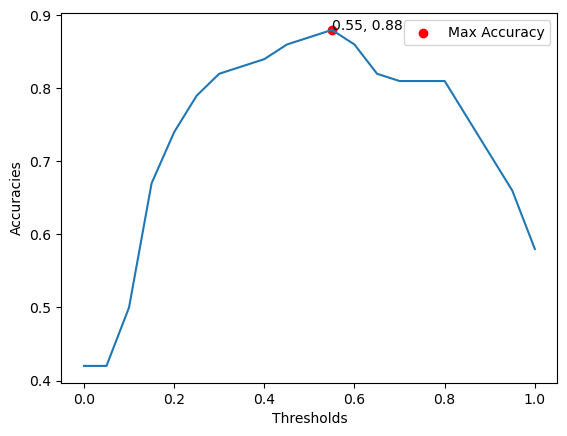

0.55 0.88


<Figure size 640x480 with 0 Axes>

2024-03-14 11:53:09,771 - INFO     - Executing shutdown due to inactivity...
2024-03-14 11:53:13,883 - INFO     - Executing shutdown...
2024-03-14 11:53:13,895 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [22]:
def get_optimal_threshold(y_pred_prob):
    # Create array of thresholds (0-1 with increments of 0.05)
    custom_thresholds = np.linspace(0, 1, 21)
    accuracies = []

    for threshold in custom_thresholds:
        # y_pred that abides by the custom threshold
        y_pred_custom = (y_pred_prob >= threshold)

        # Evaluate the model using the custom threshold
        accuracies.append(accuracy_score(y_test, y_pred_custom))

    max_accuracy = max(accuracies)
    max_index = accuracies.index(max_accuracy)

    optimal_threshold = custom_thresholds[max_index]

    # Plotting accuracy for various acceptance thresholds
    ax = sns.lineplot(x = custom_thresholds, y = accuracies)
    ax.scatter(optimal_threshold, max_accuracy, color='red', label='Max Accuracy')

    # Set x and y labels
    ax.set(xlabel='Thresholds', ylabel='Accuracies')

    ax.annotate(f'{optimal_threshold}, {max_accuracy}', (optimal_threshold, max_accuracy))

    plt.legend()
    plt.show()
    plt.clf()
    
    return optimal_threshold, max_accuracy


# Create logistic regression model
lr = LogisticRegression()

# Fit training data
lr.fit(X_train, y_train)

# Predict if the game is a win or a loss on the test data
y_pred = lr.predict(X_test)

# Confidence the model has in each of its predictions
y_pred_prob = lr.predict_proba(X_test)[:, 1]

optimal_threshold, max_accuracy = get_optimal_threshold(y_pred_prob)
print(optimal_threshold, max_accuracy)

# Hyperparameter Tuning
Now that we have determined an optimal acceptance threshold, we can tune the hyperparamter C the inverse of regularization stregth. **It has been determined that the default value of 1 is ideal.**

In [29]:
def parameter_tuning(model, param_grid, n_folds, scoring, optimal_threshold):

    # Create a grid search object with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring=scoring)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    # Confidence model has in each of its predictions
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    y_pred_optimal = (y_pred_prob >= optimal_threshold)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_optimal)
    
    print(f"Best hyperparameters: {best_params}")
    print(f"Accuracy on the test set: {accuracy}")
    
    return best_params, accuracy

# Number of cross-validation folds
n_folds = 5

# Define hyperparameter grid for grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

best_params, accuracy = parameter_tuning(lr, param_grid, n_folds, 'accuracy', optimal_threshold)

Best hyperparameters: {'C': 1}
Accuracy on the test set: 0.88
